In [1]:
!pip install opendatasets

In [2]:
import opendatasets as od
import os
from google.colab import files

import matplotlib.pyplot as plt
import random
from PIL import Image
import seaborn as sns

from keras.preprocessing.image import ImageDataGenerator

from sklearn.model_selection import train_test_split

import tensorflow as tf
from keras.applications import VGG19

from keras.models import Model, load_model
from keras.layers import Dense, Flatten, GlobalAveragePooling2D
from keras.optimizers import Adam

import pandas as pd
import numpy as np

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [3]:
# {"username":"miguelgallego","key":"6a7a2546d0b0a5683db1abd67fc0380c"}
dataset_link = "https://www.kaggle.com/datasets/harishkumardatalab/food-image-classification-dataset"
od.download(dataset_link)

Skipping, found downloaded files in "./food-image-classification-dataset" (use force=True to force download)


In [4]:
# Ruta de la carpeta principal del conjunto de datos
dataset_dir = "/content/food-image-classification-dataset/Food Classification dataset"

# Lista de carpetas dentro de la carpeta principal
subdirectories = os.listdir(dataset_dir)
print("Contenido de la carpeta principal:")
print(subdirectories)

Contenido de la carpeta principal:
['Baked Potato', 'sushi', 'pakode', 'Fries', 'chai', 'paani_puri', 'kadai_paneer', 'Donut', 'burger', 'Hot Dog', 'chapati', 'Taco', 'samosa', 'momos', 'chole_bhature', 'dal_makhani', 'Taquito', 'apple_pie', 'kaathi_rolls', 'pav_bhaji', 'masala_dosa', 'pizza', 'ice_cream', 'fried_rice', 'dhokla', 'Crispy Chicken', 'omelette', 'jalebi', 'cheesecake', 'chicken_curry', 'Sandwich', 'butter_naan', 'kulfi', 'idli']


In [5]:
# Lista de clases de alimentos
classes = subdirectories
num_classes = len(classes)
print(f'Número de clases {num_classes}')

Número de clases 34


In [6]:
# Directorio raíz del conjunto de datos
dataset_root = "/content/food-image-classification-dataset/Food Classification dataset"

# # Muestra ejemplos de imágenes de cada clase
# num_examples_per_class = 3
# for food_class in classes:
#     class_dir = os.path.join(dataset_root, food_class)
#     image_files = os.listdir(class_dir)
#     random.shuffle(image_files)  # Baraja las imágenes para mostrar ejemplos aleatorios
#     plt.figure(figsize=(12, 4))
#     for i in range(num_examples_per_class):
#         img_path = os.path.join(class_dir, image_files[i])
#         img = Image.open(img_path)
#         plt.subplot(1, num_examples_per_class, i + 1)
#         plt.imshow(img)
#         plt.title(food_class)
#     plt.show()


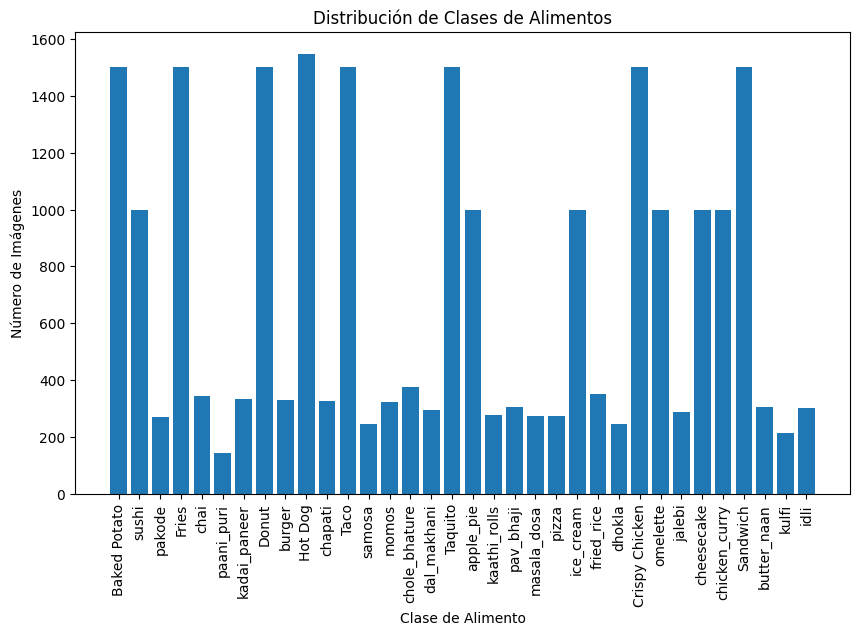


Número total de imágen: 23873


In [7]:
# Calcula el número de imágenes por clase
num_images_per_class = {food_class: len(os.listdir(os.path.join(dataset_root, food_class))) for food_class in classes}

# Muestra la distribución de clases
plt.figure(figsize=(10, 6))
plt.bar(num_images_per_class.keys(), num_images_per_class.values())
plt.xlabel('Clase de Alimento')
plt.ylabel('Número de Imágenes')
plt.title('Distribución de Clases de Alimentos')
plt.xticks(rotation=90)
plt.show()

n_images = sum(num_images_per_class.values())
print(f"\nNúmero total de imágen: {n_images}")

In [8]:
# Calcula el número de imágenes por clase
num_images_per_class = {food_class: len(os.listdir(os.path.join(dataset_root, food_class))) for food_class in classes}
num_images_per_class

{'Baked Potato': 1500,
 'sushi': 1000,
 'pakode': 269,
 'Fries': 1500,
 'chai': 344,
 'paani_puri': 144,
 'kadai_paneer': 334,
 'Donut': 1500,
 'burger': 331,
 'Hot Dog': 1548,
 'chapati': 327,
 'Taco': 1500,
 'samosa': 244,
 'momos': 323,
 'chole_bhature': 376,
 'dal_makhani': 295,
 'Taquito': 1500,
 'apple_pie': 1000,
 'kaathi_rolls': 279,
 'pav_bhaji': 305,
 'masala_dosa': 273,
 'pizza': 275,
 'ice_cream': 1000,
 'fried_rice': 350,
 'dhokla': 245,
 'Crispy Chicken': 1500,
 'omelette': 1000,
 'jalebi': 288,
 'cheesecake': 1000,
 'chicken_curry': 1000,
 'Sandwich': 1500,
 'butter_naan': 307,
 'kulfi': 214,
 'idli': 302}

In [9]:
# Obtiene las dimensiones de una imagen de muestra
random_class = random.choice(classes)
random_img = random.choice(os.listdir(os.path.join(dataset_root,random_class)))
sample_image_path = os.path.join(dataset_root, random_class, random_img)
sample_image = Image.open(sample_image_path)
image_width, image_height = sample_image.size
print(f"Ancho de imagen: {image_width}px, Alto de imagen: {image_height}px")


Ancho de imagen: 259px, Alto de imagen: 194px


In [10]:
# Redimensionado de las imágenes
target_size = (224, 224)  # Tamaño deseado de las imágenes

def preprocess_image(image_path):
    image = Image.open(image_path)
    image = image.resize(target_size, Image.LANCZOS)  # Redimensionar la imagen
    # Realizar otras transformaciones, como normalización de píxeles, aquí si es necesario?
    return image

In [11]:
# Inicializa listas para almacenar las rutas de imágenes y etiquetas
image_paths = []
labels = []

# Itera a través de las carpetas de clases de alimentos
for food_class in subdirectories:
    class_dir = os.path.join(dataset_dir, food_class)
    if os.path.isdir(class_dir):
        # Enumera los archivos de imágenes en la carpeta de la clase
        class_image_paths = [os.path.join(class_dir, filename) for filename in os.listdir(class_dir)]
        # Agrega las rutas de imágenes a la lista
        image_paths.extend(class_image_paths)
        # Agrega las etiquetas correspondientes (nombre de la clase) a la lista
        labels.extend([food_class] * len(class_image_paths))

In [12]:
# %%time

# # Aplicar la función par cambiar el tamaño de las imágnes
# dic_imag_path = {im: preprocess_image(im) for im in image_paths}

In [13]:
# # Comprobar cómo quedan las imagnes despúes de remodelarlas
# n = random.randint(1, n_images)
# print(f"Label imagen: {labels[n]}")
# image_width, image_height = dic_imag_path[image_paths[n]].size
# print(f"Ancho de imagen: {image_width}px, Alto de imagen: {image_height}px")
# dic_imag_path[image_paths[n]]


In [14]:
# Crear un DataFrame con las rutas de las imágenes y las etiquetas
data = {'filename': image_paths, 'class': labels}
df = pd.DataFrame(data)
df.groupby('class').count()

,filename
class,
Baked Potato,1500
Crispy Chicken,1500
Donut,1500
Fries,1500
Hot Dog,1548
Sandwich,1500
Taco,1500
Taquito,1500
apple_pie,1000


In [15]:
desired_min_samples = 800
desired_max_samples = 250

# Lista de clases con más de 800 y menos de 250 muestras
df_classes = df['class'].value_counts()
overpopulated_classes = df_classes[df_classes > desired_min_samples].index.tolist()
underpopulated_classes = df_classes[df['class'].value_counts() < desired_max_samples].index.tolist()

# Crear un nuevo conjunto de datos balanceado
new_data = []

for i_class in overpopulated_classes:
    # Filtra las muestras de la clase actual
    actual_class = df[df['class'] == i_class]

    # Selecciona aleatoriamente 800 muestras de la clase actual
    selected_samples = actual_class.sample(n=desired_min_samples, random_state=42)

    # Agrega las muestras seleccionadas al nuevo conjunto de datos
    new_data.append(selected_samples)

# Concatena los datos de todas las clases seleccionadas
clipped_data = pd.concat(new_data)

# Conjunto de datos con 800 muestras por cada clase en overpopulated_classes
clipped_data.groupby('class').count()


,filename
class,
Baked Potato,800
Crispy Chicken,800
Donut,800
Fries,800
Hot Dog,800
Sandwich,800
Taco,800
Taquito,800
apple_pie,800


In [16]:
# Elimina las filas correspondientes a estas clases del DataFrame original (<250 y >800)
data_to_incrase = df[~df['class'].isin(underpopulated_classes)]
data_to_incrase = df[~df['class'].isin(overpopulated_classes)]

# Clases con menos de 800 muestras y más de 250 muestras.
data_to_incrase.groupby('class').count()

,filename
class,
burger,331
butter_naan,307
chai,344
chapati,327
chole_bhature,376
dal_makhani,295
dhokla,245
fried_rice,350
idli,302


In [17]:
# Dataset filtrado
filtered_data = pd.concat([clipped_data, data_to_incrase])
filtered_data.groupby('class').count()

,filename
class,
Baked Potato,800
Crispy Chicken,800
Donut,800
Fries,800
Hot Dog,800
Sandwich,800
Taco,800
Taquito,800
apple_pie,800


In [ ]:
# Dividir los datos en entrenamiento (70%) y temporales (30%)
train_data, temp_data = train_test_split(df, test_size=0.3, random_state=42)

# Dividir los datos temporales en validación (50%) y prueba (50%)
validation_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=42)

In [ ]:
# from collections import defaultdict

# # Define un diccionario para realizar un seguimiento del número de muestras por clase
# class_counts = defaultdict(int)

# # Establece la cantidad mínima deseada de muestras por clase (en este caso, 800)
# desired_min_samples = 800

# # Lista de DataFrames para almacenar las divisiones equilibradas
# balanced_dataframes = []

# # Itera sobre el conjunto de datos original y crea divisiones equilibradas
# for dataframe in [train_data, validation_data, test_data]:
#     # Filtra las clases con más de 800 muestras
#     overpopulated_classes = [cls for cls, count in class_counts.items() if count > desired_min_samples]
#     print(overpopulated_classes)
#     # Inicializa un DataFrame para esta división copiando el DataFrame original
#     balanced_dataframe = dataframe.copy()

#     for cls in class_counts:
#         # Si la clase está sobrepoblada, selecciona aleatoriamente 800 muestras
#         if cls in overpopulated_classes:
#             subset = dataframe[dataframe['class'] == cls].sample(n=desired_min_samples, random_state=42)
#             # Actualiza el DataFrame balanceado con el subconjunto
#             balanced_dataframe = pd.concat([balanced_dataframe, subset])

#     # Agrega el DataFrame balanceado a la lista
#     balanced_dataframes.append(balanced_dataframe)

# # Divide los DataFrames balanceados en entrenamiento, validación y prueba
# train_data_balanced, validation_data_balanced, test_data_balanced = balanced_dataframes



In [ ]:
# overpopulated_classes

In [ ]:
# print(train_data_balanced.groupby('class').count())
# print(validation_data_balanced.groupby('class').count())
# print(test_data_balanced.groupby('class').count())

In [ ]:
# Crea y define el ImageDataGenerator

datagen = ImageDataGenerator(
    rescale=1.0/255, # Normalizar los valores de píxeles al rango [0, 1]
    # preprocessing_function=keras.applications.vgg19.preprocess_input # imagenes rgb a bgr
    # rotation_range=20,      # Rango de rotación aleatoria
    # width_shift_range=0.2,  # Desplazamiento horizontal aleatorio
    # height_shift_range=0.2, # Desplazamiento vertical aleatorio
    # shear_range=0.2,        # Distorsión de corte aleatoria
    # zoom_range=0.2,         # Ampliación aleatoria
    # horizontal_flip=True,   # Volteo horizontal aleatorio
    # fill_mode='nearest'     # Estrategia de relleno
)

batch_size = 32

# Crear generadores de datos para entrenamiento, validación y prueba
train_generator = datagen.flow_from_dataframe(
    dataframe = train_data,
    target_size=(224, 224),  # Ajusta el tamaño según tu modelo
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

validation_generator = datagen.flow_from_dataframe(
    dataframe = validation_data,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False  # No es necesario mezclar los datos de validación
)

test_generator = datagen.flow_from_dataframe(
    dataframe = test_data,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False  # No es necesario mezclar los datos de prueba
)

images, img_labels = next(train_generator)
print("Forma del lote de imágenes:", images.shape)

Found 16711 validated image filenames belonging to 34 classes.
Found 3581 validated image filenames belonging to 34 classes.
Found 3581 validated image filenames belonging to 34 classes.
Forma del lote de imágenes: (32, 224, 224, 3)


In [ ]:
# # Tomar un lote de imágenes del generador
# images, img_labels = next(train_generator)

# # Verificar las formas de las imágenes en el lote
# print("Forma del lote de imágenes:", images.shape)  # Debería ser (batch_size, height, width, channels)

# # Seleccionar una imagen del lote (por ejemplo, la primera imagen)
# image = images[0]  # Cambia el índice si deseas visualizar otra imagen

# # Mostrar la imagen utilizando Matplotlib
# plt.figure(figsize=(3, 3))
# plt.imshow(image.squeeze())  # Asegúrate de usar 'gray' para imágenes en escala de grises
# plt.axis('off')  # Deshabilita los ejes
# plt.title(f'Clase: {img_labels[0]}')  # Muestra la etiqueta de clase (cambia si no usas one-hot encoding)
# plt.show()


In [ ]:
# Cargar y visualizar modelo preentrenado
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.summary()

In [ ]:
# Congelar capas
for layer in base_model.layers:
    layer.trainable = False

# Agregar capas personalizadas para datos
x = base_model.output
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dense(128, activation='relu')(x)
predictions = Dense(34, activation='softmax')(x)

# Crea un nuevo modelo con la capa de salida modificada
new_model = Model(inputs=base_model.input, outputs=predictions)

In [ ]:
# Compila el modelo
new_model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.0001), metrics=['accuracy'])

# Entrenar el modelo utilizando los generadores de datos
epochs = 10  # Número de épocas
history = new_model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,  # Número total de lotes por época
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,  # Número total de lotes de validación por época
)

In [ ]:
# Guarda el modelo entrenado
new_model.save('second_model_version.h5')
new_model.save('my_second_model.keras')

In [ ]:
# Descarga el modelo entrenado
files.download('second_model_version.h5')
files.download('my_second_model.keras')

In [ ]:
# Cargar el modelo
new_model = load_model('/content/firs_model_version.h5')

In [ ]:
# Obtiene perdida y precisión en el conjunto de prueba
test_loss, test_accuracy = new_model.evaluate(validation_generator)
print(f"Pérdida en el conjunto de prueba: {test_loss}")
print(f"Precisión en el conjunto de prueba: {test_accuracy}")

In [ ]:
# Predicciones del modelo en el conjunto de datos de prueba
predictions = new_model.predict(test_generator)
# Convierte las predicciones en etiquetas de clase (por ejemplo, utilizando np.argmax)
predicted_classes = np.argmax(predictions, axis=1)

# Calcula la matriz de confusión
true_classes = test_generator.classes
confusion = confusion_matrix(true_classes, predicted_classes)
print("Matriz de Confusión:")
print(confusion)

# Visualizar la matriz de confusión como un mapa de calor
plt.figure(figsize=(10, 8))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.xlabel('Predicciones')
plt.ylabel('Etiquetas verdaderas')
plt.title('Matriz de Confusión')
plt.show()

In [ ]:
# Calcula precision, recall y f1-score por clase
report = classification_report(true_classes, predicted_classes, target_names=class_names)
print("Reporte de Clasificación:")
print(report)

In [ ]:
# Generar un informe de clasificación
class_labels = list(test_generator.class_indices.keys())
class_report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print("Informe de Clasificación:\n", class_report)